Downloading dataset related to cucumber diseases

In [1]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/y6d3z6f8z9-1.zip

--2023-08-10 21:02:59--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/y6d3z6f8z9-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.100.168, 52.218.36.19, 3.5.65.178, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.100.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2780364487 (2.6G) [application/zip]
Saving to: ‘y6d3z6f8z9-1.zip’

y6d3z6f8z9-1.zip    100%[===================>]   2.59G  68.9MB/s    in 40s     

2023-08-10 21:03:40 (65.8 MB/s) - ‘y6d3z6f8z9-1.zip’ saved [2780364487/2780364487]



In [2]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

Extracting dataset

In [3]:
local_zip = '/content/y6d3z6f8z9-1.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('archive-file')
zip_ref.close()
local_zip = '/content/archive-file/Cucumber Disease Recognition Dataset/Augmented Image.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('cucumber-dataset')
zip_ref.close()

This function enables us to obtain a comprehensive list of file paths that currently exist within a specified directory.

In [4]:
def get_file_paths(directory):
    file_paths = []
    for root, directories, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
    return file_paths

Store the file paths corresponding to dataset images for each class, as they will be utilized in the creation of our dataframe.

In [5]:
Anthracnose = get_file_paths('/content/cucumber-dataset/Augmented Image/Anthracnose')
Bacterial_Wilt = get_file_paths('/content/cucumber-dataset/Augmented Image/Bacterial Wilt')
Downy_Mildew = get_file_paths('/content/cucumber-dataset/Augmented Image/Downy Mildew')
Fresh_Leaf = get_file_paths('/content/cucumber-dataset/Augmented Image/Fresh Leaf')
Gummy_Stem_Blight = get_file_paths('/content/cucumber-dataset/Augmented Image/Gummy Stem Blight')

labels related to leaf diseases

In [6]:
labels = ['Anthracnose','Downy_Mildew','Bacterial_Wilt','Gummy_Stem_Bligh','Fresh_Leaf']



In this section, we provide a demonstration of image segmentation to highlight regions of interest.

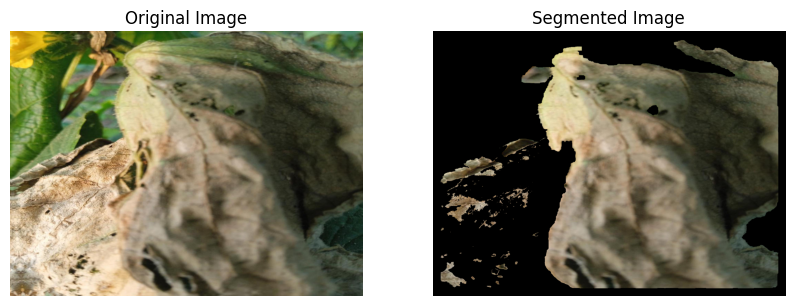

In [ ]:
def segment_image(image_path):
    # Read the image
    original_image = cv2.imread(image_path)
    if original_image is None:
        raise ValueError("Unable to read the image. Please provide a valid image path.")

    # Create a mask and initialize it with zeros
    mask = np.zeros(original_image.shape[:2], np.uint8)

    # Initialize background and foreground models
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Define a rectangle around the object you want to segment
    rect = (50, 50, original_image.shape[1] - 100, original_image.shape[0] - 100)

    # Apply GrabCut algorithm
    cv2.grabCut(original_image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Create a binary mask where 0 and 2 are background, and 1 and 3 are foreground
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Apply the binary mask to the original image
    segmented_image = original_image * mask2[:, :, np.newaxis]

    return original_image, segmented_image

def display_side_by_side(original_image, segmented_image):
    # Convert BGR to RGB for displaying with matplotlib
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

    # Plot the images side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image_rgb)
    plt.title('Segmented Image')
    plt.axis('off')

    plt.show()

image_path = Anthracnose[0]
original_image, segmented_image = segment_image(image_path)
display_side_by_side(original_image, segmented_image)

In [ ]:

def display_images_with_labels(image_paths, labels):
    num_images = len(image_paths)
    num_rows = 3
    num_cols = (num_images + num_rows - 1) // num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            if idx < num_images:
                image_path = image_paths[idx]
                label = labels[idx]

                # Load and display the image
                img = mpimg.imread(image_path)
                axes[i, j].imshow(img)
                axes[i, j].set_title(label)
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')

    plt.show()

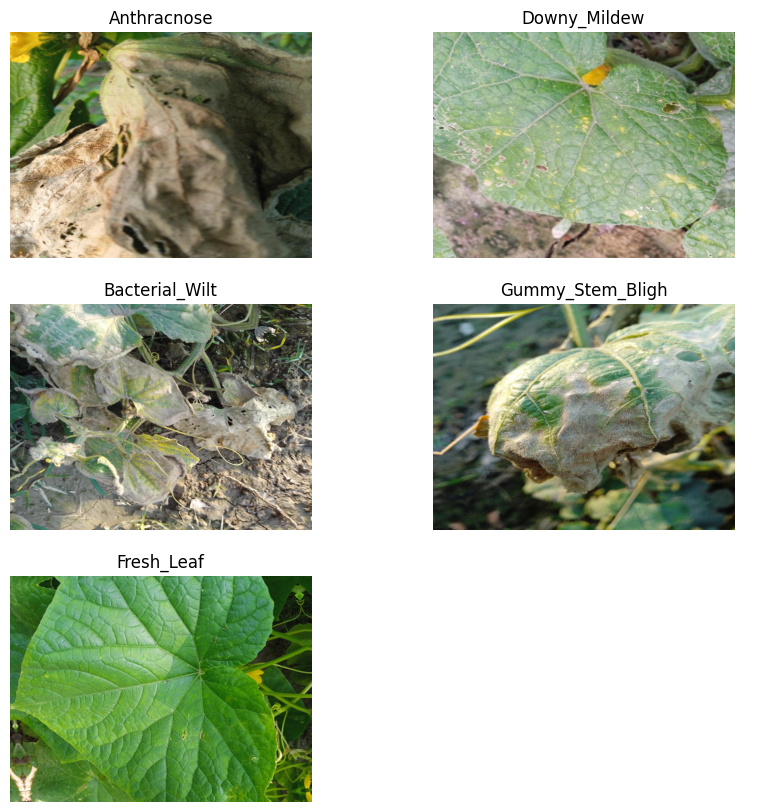

In [ ]:
img_samples = [Anthracnose[0],Downy_Mildew[1],Bacterial_Wilt[2],Gummy_Stem_Blight[6],Fresh_Leaf[7]]
display_images_with_labels(img_samples,labels)

In [7]:
def create_dataframe(image_paths_lists, class_labels):
    # Flatten the list of lists containing image paths
    all_image_paths = [path for sublist in image_paths_lists for path in sublist]

    # Create the class labels as one-hot encoding
    num_classes = len(image_paths_lists)
    one_hot_labels = np.zeros((len(all_image_paths), num_classes))
    for class_idx, image_paths in enumerate(image_paths_lists):
        for path in image_paths:
            idx = all_image_paths.index(path)
            one_hot_labels[idx, class_idx] = 1

    # Create the DataFrame
    data = {'image_path': all_image_paths}
    for i in range(num_classes):
        data[class_labels[i]] = one_hot_labels[:, i]

    df = pd.DataFrame(data)
    return df


In [8]:
df = create_dataframe([Anthracnose,Downy_Mildew,Bacterial_Wilt,Gummy_Stem_Blight,Fresh_Leaf],labels)
df.reset_index()
df = df.sample(frac=1)


In [9]:
df.head()

,image_path,Anthracnose,Downy_Mildew,Bacterial_Wilt,Gummy_Stem_Bligh,Fresh_Leaf
3536,/content/cucumber-dataset/Augmented Image/Fres...,0.0,0.0,0.0,0.0,1.0
1500,/content/cucumber-dataset/Augmented Image/Down...,0.0,1.0,0.0,0.0,0.0
2848,/content/cucumber-dataset/Augmented Image/Gumm...,0.0,0.0,0.0,1.0,0.0
1727,/content/cucumber-dataset/Augmented Image/Bact...,0.0,0.0,1.0,0.0,0.0
1886,/content/cucumber-dataset/Augmented Image/Bact...,0.0,0.0,1.0,0.0,0.0


Class size comparasion between 5 class of cucumber leaf disease dataset

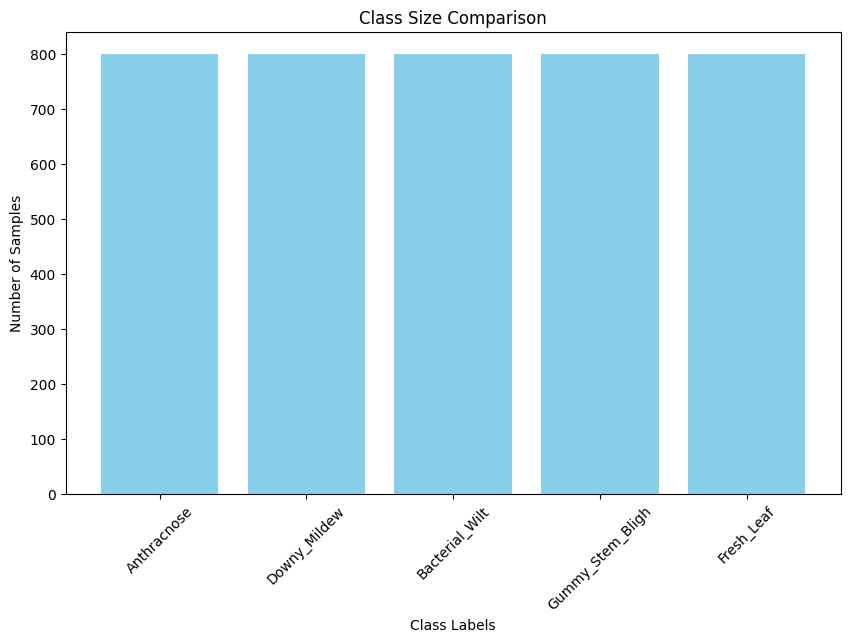

In [ ]:
import matplotlib.pyplot as plt

def draw_class_bar_chart(data_lists, class_labels):
    class_sizes = [len(data) for data in data_lists]

    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, class_sizes, color='skyblue')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')
    plt.xticks(range(len(class_labels)), class_labels,rotation=45)
    plt.title('Class Size Comparison')
    plt.show()

draw_class_bar_chart([Anthracnose,Downy_Mildew,Bacterial_Wilt,Gummy_Stem_Blight,Fresh_Leaf],labels)

spliting data set to train and test subset

In [10]:
from sklearn.model_selection import train_test_split
train_df , test_df = train_test_split(df,test_size=0.2)

model architecture

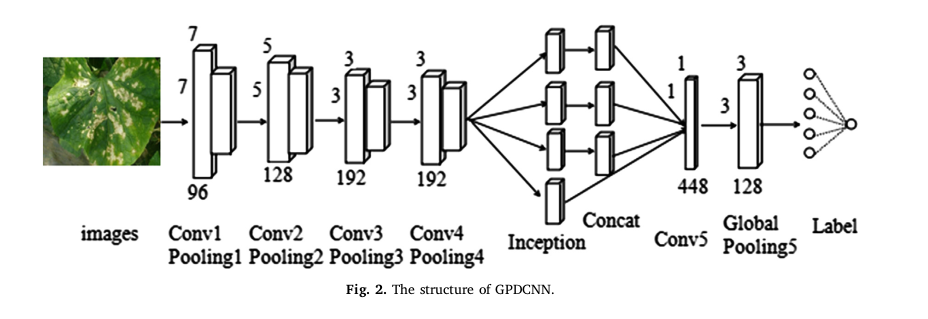

defining inception module

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate

def inception_module(x, filters):
    # 1x1 Convolution for dimensionality reduction
    conv1x1_1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 3x3 Convolution
    conv3x3 = Conv2D(filters[1], (3, 3), padding='same', activation='relu')(x)

    # 5x5 Convolution
    conv5x5 = Conv2D(filters[2], (5, 5), padding='same', activation='relu')(x)

    # MaxPooling
    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_2 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(maxpool)

    # Concatenate the outputs along the channel axis
    inception_output = concatenate([conv1x1_1, conv3x3, conv5x5, conv1x1_2], axis=-1)
    return inception_output

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, concatenate, GlobalAveragePooling2D

# Assuming you have already defined the inception_module function

# Input layer
Input = tf.keras.Input(shape=(256, 256, 3))

# Rest of the layers
conv1 = Conv2D(filters=96, kernel_size=11, dilation_rate=2)(Input)
pool1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv1)
conv2 = Conv2D(filters=128, kernel_size=5, dilation_rate=2)(pool1)
pool2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv2)
conv3 = Conv2D(filters=192, kernel_size=3, dilation_rate=2)(pool2)
pool3 = MaxPool2D(pool_size=(2, 2), strides=2)(conv3)
conv4 = Conv2D(filters=192, kernel_size=3, dilation_rate=2)(pool3)
pool4 = MaxPool2D(pool_size=(2, 2), strides=2)(conv4)

# Inception module
inception_output = inception_module(pool4, filters=[64, 128, 32, 32])

# Final Convolutional Layer
conv5 = Conv2D(filters=128, kernel_size=3, dilation_rate=2)(inception_output)

# Global Average Pooling
global_avg_pooling = GlobalAveragePooling2D()(conv5)

# Classification layer (with a different name than 'Dense')
output_layer = tf.keras.layers.Dense(5, activation='softmax')(global_avg_pooling)

# Create the model
model = tf.keras.Model(inputs=Input, outputs=output_layer)

# Compile the model and specify the loss function, optimizer, and metrics as needed
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Downloading alex-net pretrained weights

In [13]:
!wget http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy

--2023-08-10 21:04:34--  http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243861814 (233M)
Saving to: ‘bvlc_alexnet.npy’

bvlc_alexnet.npy    100%[===================>] 232.56M  30.0MB/s    in 8.4s    

2023-08-10 21:04:43 (27.7 MB/s) - ‘bvlc_alexnet.npy’ saved [243861814/243861814]



In [14]:
import numpy as np
alexnet_weights = np.load('/content/bvlc_alexnet.npy', encoding='bytes',allow_pickle=True).item()

set alex net weights to first four conv layer of defined model

In [15]:
print('alexnet weights and biases shape : ')
for ind in range(1, 5):
    print('conv{} weights shape: {}'.format(ind, alexnet_weights['conv' + str(ind)][0].shape))
    print('conv{} biase shape: {}'.format(ind, alexnet_weights['conv' + str(ind)][1].shape))



alexnet weights and biases shape : 
conv1 weights shape: (11, 11, 3, 96)
conv1 biase shape: (96,)
conv2 weights shape: (5, 5, 48, 256)
conv2 biase shape: (256,)
conv3 weights shape: (3, 3, 256, 384)
conv3 biase shape: (384,)
conv4 weights shape: (3, 3, 192, 384)
conv4 biase shape: (384,)


In [16]:
weights_biases_dict = {}

# Iterate through each layer of the model
for layer in model.layers:
    # Check if the layer has trainable weights (weights and biases)
    if layer.trainable_weights:
        # Extract the layer's name
        layer_name = layer.name
        # Get the weights and biases as NumPy arrays
        weights = layer.get_weights()[0]  # Index 0 for weights
        biases = layer.get_weights()[1]  # Index 1 for biases

        # Store the weights and biases in the dictionary
        weights_biases_dict[layer_name] = weights

In [17]:
weights_keys = list(weights_biases_dict.keys())

In [18]:
#fine-tuning and set first conv layer with alexnet weights
print('alexnet first conv layer weights shape :',alexnet_weights['conv1'][0].shape)
print('alexnet first conv layer biases shape :',alexnet_weights['conv1'][1].shape)
print('our model first conv layer weights shape :',weights_biases_dict[weights_keys[0]].shape)
#weights shape matches we simply set alexnet weights to out model without any modification
model.get_layer(weights_keys[0]).set_weights(alexnet_weights['conv1'])

alexnet first conv layer weights shape : (11, 11, 3, 96)
alexnet first conv layer biases shape : (96,)
our model first conv layer weights shape : (11, 11, 3, 96)


In [19]:
#fine-tuning and set first conv layer with alexnet weights
print('alexnet first conv layer weights shape :',alexnet_weights['conv2'][0].shape)
print('alexnet first conv layer biases shape :',alexnet_weights['conv2'][1].shape)
print('our model first conv layer weights shape :',weights_biases_dict[weights_keys[1]].shape)
#weights mismatch in 3rd axis first we fill 3rd axis of alex net weights with random values to create array of shape (5,5,96,256)
original_shape = (5, 5, 48, 256)
desired_shape = (5, 5, 96, 256)
original_array = alexnet_weights['conv2'][0]
new_array = np.zeros(desired_shape)
# Fill the new_array with values from the original array
# The original_array occupies the first 48 rows of the new_array along the third dimension (index 2)
new_array[:, :, :48, :] = original_array
# Fill the rest of the new_array with random values from Gaussian distribution
new_array[:, :, 48:, :] = np.random.randn(*new_array[:, :, 48:, :].shape)*0.01

#now we should take first 128 matrices of 4th axis (for both weights and biases) to form out weight
conv2d_2_fine_tuned_weights = new_array[:,:,:,:128]
conv2d_2_fine_tuned_biases = alexnet_weights['conv2'][1][:128]
print('fine_tuned_weights shape :',conv2d_2_fine_tuned_weights.shape)
print('fine_tuned_biases shape :',conv2d_2_fine_tuned_biases.shape)
model.get_layer(weights_keys[1]).set_weights([conv2d_2_fine_tuned_weights,conv2d_2_fine_tuned_biases])

alexnet first conv layer weights shape : (5, 5, 48, 256)
alexnet first conv layer biases shape : (256,)
our model first conv layer weights shape : (5, 5, 96, 128)
fine_tuned_weights shape : (5, 5, 96, 128)
fine_tuned_biases shape : (128,)


In [20]:
#fine-tuning and set first conv layer with alexnet weights
print('alexnet first conv layer weights shape :',alexnet_weights['conv3'][0].shape)
print('alexnet first conv layer biases shape :',alexnet_weights['conv3'][1].shape)
print('our model first conv layer weights shape :',weights_biases_dict[weights_keys[2]].shape)
#we sample from alexnet to creat new weights for out model
conv2d_3_fine_tuned_weights = alexnet_weights['conv3'][0][:,:,:128,:192]
conv2d_3_fine_tuned_biases = alexnet_weights['conv3'][1][:192]
model.get_layer(weights_keys[2]).set_weights([conv2d_3_fine_tuned_weights,conv2d_3_fine_tuned_biases])

alexnet first conv layer weights shape : (3, 3, 256, 384)
alexnet first conv layer biases shape : (384,)
our model first conv layer weights shape : (3, 3, 128, 192)


In [21]:
#fine-tuning and set first conv layer with alexnet weights
print('alexnet first conv layer weights shape :',alexnet_weights['conv4'][0].shape)
print('alexnet first conv layer biases shape :',alexnet_weights['conv4'][1].shape)
print('our model first conv layer weights shape :',weights_biases_dict[weights_keys[3]].shape)
#we sample from alexnet to creat new weights for out model
conv2d_4_fine_tuned_weights = alexnet_weights['conv4'][0][:,:,:,:192]
conv2d_4_fine_tuned_biases = alexnet_weights['conv4'][1][:192]
model.get_layer(weights_keys[3]).set_weights([conv2d_4_fine_tuned_weights,conv2d_4_fine_tuned_biases])

alexnet first conv layer weights shape : (3, 3, 192, 384)
alexnet first conv layer biases shape : (384,)
our model first conv layer weights shape : (3, 3, 192, 192)


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 236, 236, 96  34944       ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 118, 118, 96  0          ['conv2d_18[0][0]']              
 )                              )                                                           

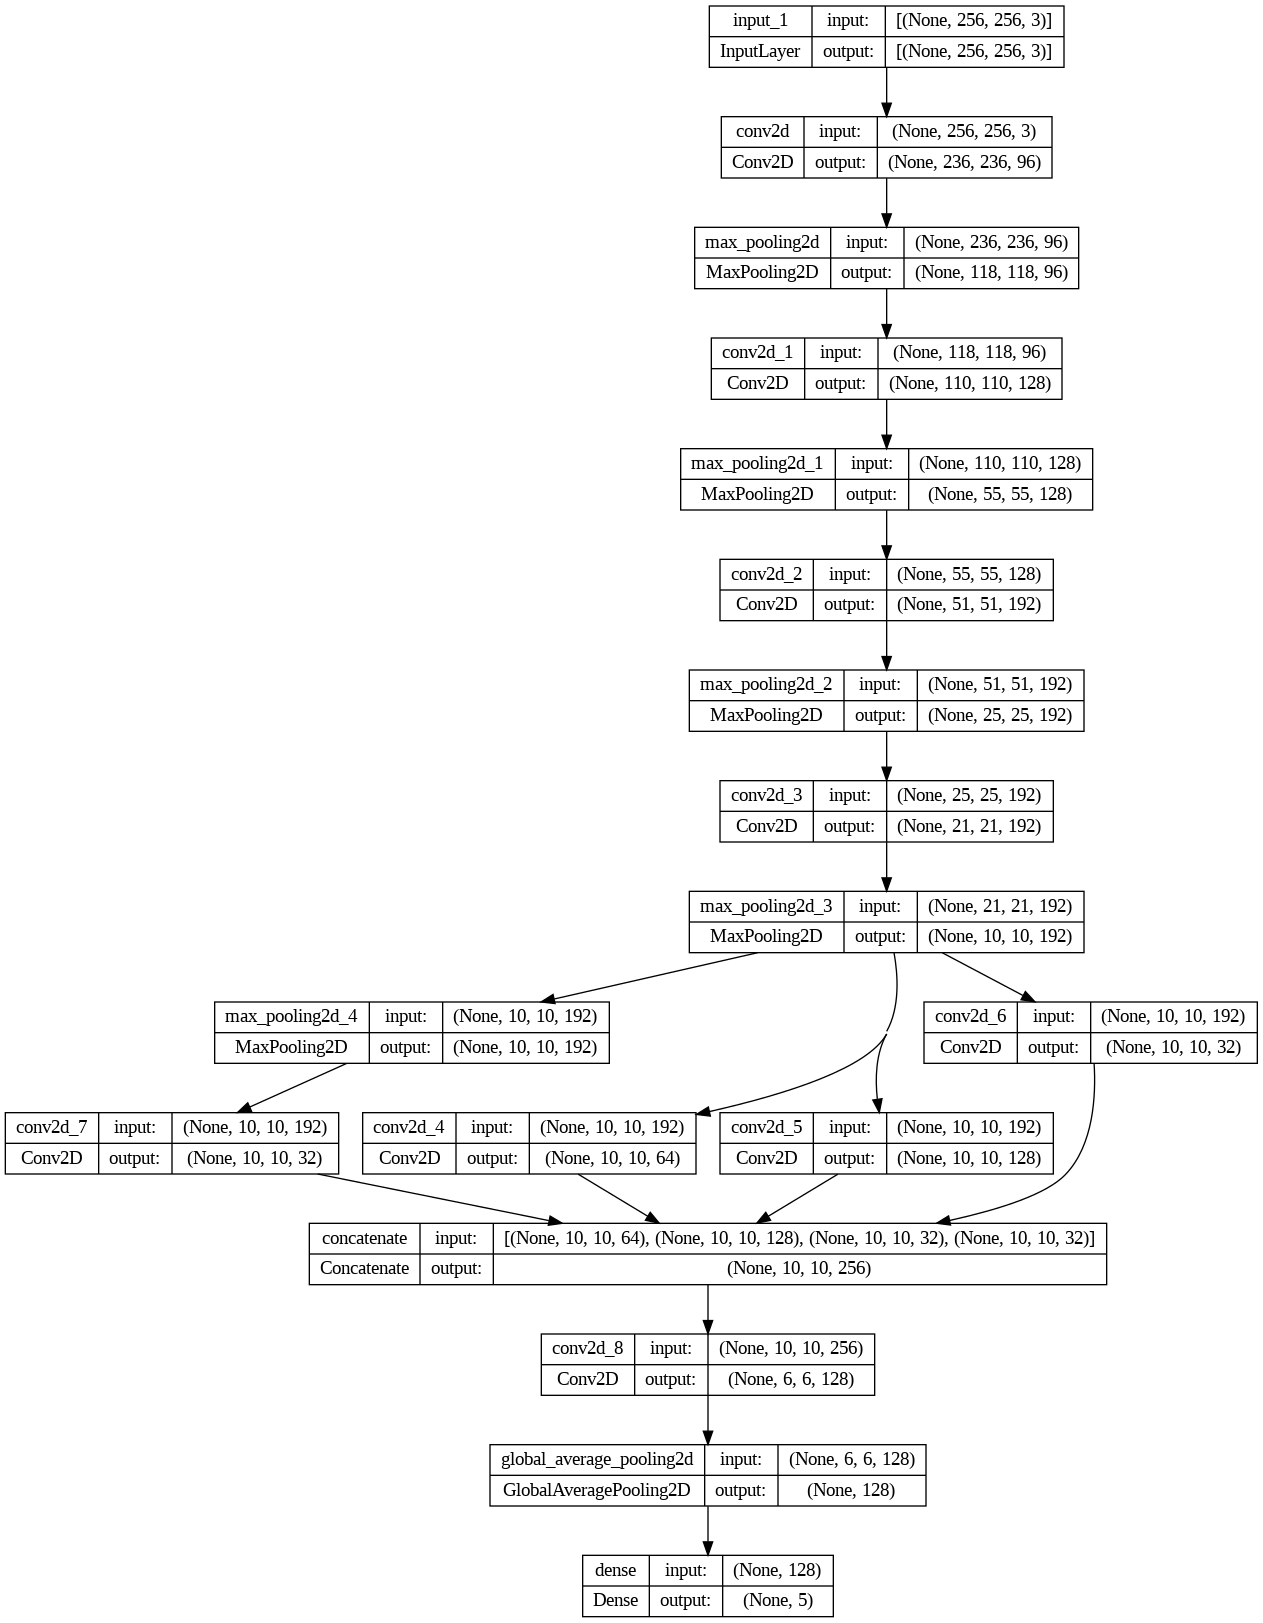

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


preprocessing images

In [22]:
from PIL import Image
def preprocess_batch_images(df) :
  images=[]
  for row in range(len(df)) :
      images.append(np.array(Image.open(df.iloc[row]["image_path"]).resize((256,256)))/255)
  return np.array(images)

In [23]:
def data_generator(data, batch_size,labels):
    num_samples = len(data)
    num_batches = num_samples // batch_size

    while True:
        data = data.sample(frac=1)
        for i in range(num_batches):
            batch_data = data.iloc[i * batch_size : (i + 1) * batch_size]

            batch_labels = batch_data[labels].values

            batch_features = preprocess_batch_images(batch_data[['image_path']])

            yield batch_features, batch_labels

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
batch_size = 64
num_epochs = 30

losses=[]
accuracies=[]
train_generator = data_generator(train_df, batch_size,labels)
steps_per_epoch = len(train_df) // batch_size

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    progress_bar = tqdm(range(steps_per_epoch), desc=f"Loss: 0.0000", leave=False)
    # Training loop
    for step in progress_bar:

        X_batch , y_batch = next(train_generator)
        loss, accuracy = model.train_on_batch(X_batch, y_batch)

        progress_bar.set_description("Loss: {} - accuracy: {}".format(loss,accuracy))
    losses.append(loss)
    accuracies.append(accuracy)


Epoch 1/30


Loss: 0.0000:   0%|          | 0/50 [00:00<?, ?it/s]WARNING:tensorflow:5 out of the last 17 calls to <function Model.make_train_function.<locals>.train_function at 0x7fd9a8106b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


KeyboardInterrupt: ignored

ploting loss and accuracies chages versus epoch

In [ ]:
# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()


Saving model weights

In [ ]:
model.save_weights('model_weights.hdf5')

loading model weights

In [ ]:
model.load_weights('model_weights.hdf5')

In [ ]:
test_generator = data_generator(test_df, 512,labels)

In [ ]:
X_test,y_test = next(test_generator)

In [ ]:
print('accuracy on test set :' , model.evaluate(X_test,y_test)[1])

16/16 [==============================] - 5s 116ms/step - loss: 0.1125 - accuracy: 0.9688
accuracy on test set : 0.96875


plotting confusion matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true_onehot, y_pred_softmax, classes, normalize=False):
    """
    Plots a confusion matrix.

    Parameters:
        y_true_onehot (numpy.ndarray): One-hot encoded true labels.
        y_pred_softmax (numpy.ndarray): Softmax predicted probabilities for each class.
        classes (list): List of class names (labels).
        normalize (bool): Whether to normalize the confusion matrix.

    Returns:
        None
    """

    # Convert one-hot vectors to class labels
    y_true = np.argmax(y_true_onehot, axis=1)
    y_pred = np.argmax(y_pred_softmax, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


16/16 [==============================] - 2s 114ms/step


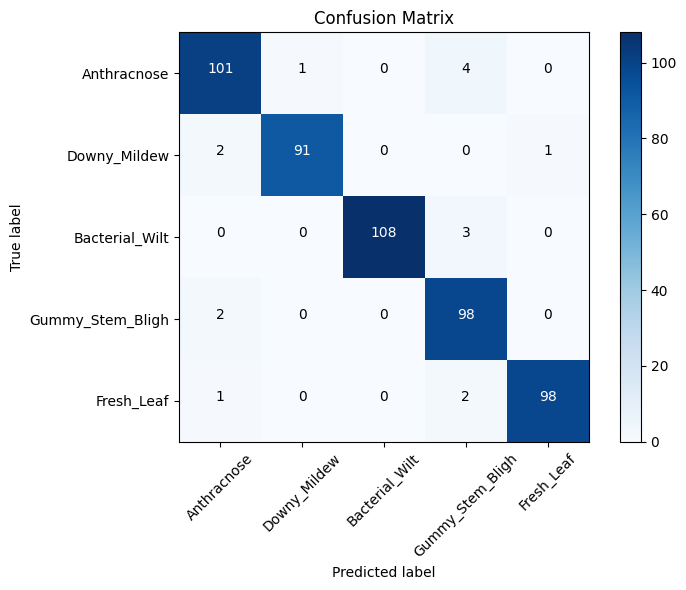

In [ ]:
plot_confusion_matrix(y_test,model.predict(X_test),labels)